# Final Project: Comparing Random Forest to CNN in Network Classification Task
This project trains two models on the ISCXVPN2016 database. For the model comparision, the project focuses on the non-VPN dataset in Scenario B of the dataset.

In [42]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()
    
    # Execute task
    yield
    
    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.3f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.000s


In [2]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, name, feat, y):
    pred = model.predict(feat)
    
    print(classification_report(y, pred))
    print(confusion_matrix(y, pred), "\n")

In [3]:
# Load Data
from scipy.io import arff
import pandas as pd
import numpy as np

data_files = [
    "dataset/Scenario/Scenario B/TimeBasedFeatures-Dataset-15s-AllinOne.arff"
]
iscx_tbf = None

for data_file in data_files:
    print(f"{data_file}")
    with open(data_file, "r") as f:
      data, meta = arff.loadarff(f)
      ndf = pd.DataFrame(data=data, columns=meta.names())
      if iscx_tbf is None:
        iscx_tbf = ndf
      else:
        iscx_tbf = pd.concat([iscx_tbf, ndf])
    
# fix a loadarff limitation with strings
iscx_tbf["class1"] = iscx_tbf["class1"].map(lambda x: x.decode("utf-8"))

iscx_tbf.head(5)

dataset/Scenario/Scenario B/TimeBasedFeatures-Dataset-15s-AllinOne.arff


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,CHAT
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,CHAT
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,CHAT
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,CHAT
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,CHAT


In [4]:
iscx_tbf.describe()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
count,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,18758.000000,...,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04,1.875800e+04
mean,9.791705e+06,6.086783e+05,6.267802e+05,3.314204e+06,2.861716e+06,1.003929e+06,9.218250e+05,8.448286e+05,6.133578e+05,2073.780095,...,4.768167e+05,1.035025e+06,3.253846e+06,3.635654e+06,4.091204e+06,5.025001e+05,2.983753e+06,3.325142e+06,3.732466e+06,4.531389e+05
std,1.438458e+07,2.243195e+06,2.326442e+06,1.062115e+07,9.652561e+06,3.141855e+06,2.495984e+06,4.336559e+06,2.516395e+06,19115.713624,...,1.404428e+06,3.534085e+06,1.342955e+07,1.356162e+07,1.400211e+07,2.813959e+06,1.334323e+07,1.347430e+07,1.390155e+07,2.785573e+06
min,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,3.346690e+05,7.000000e+00,2.000000e+00,2.597050e+04,2.454225e+04,1.154333e+04,5.626786e+03,1.145469e+02,0.000000e+00,2.599190,...,9.577449e+03,5.574602e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
50%,1.109263e+07,6.200000e+01,2.100000e+01,2.821430e+05,2.865800e+05,5.104959e+04,3.526250e+04,1.164916e+04,9.605910e+03,11.681220,...,8.412602e+04,7.518175e+04,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
75%,1.494537e+07,1.645000e+03,1.651000e+03,4.289454e+06,4.265465e+06,5.260302e+05,4.843726e+05,6.055940e+05,5.340370e+05,100.671695,...,3.119330e+05,7.659213e+05,2.767727e+06,4.248512e+06,5.690602e+06,0.000000e+00,1.943930e+06,3.333185e+06,4.696002e+06,0.000000e+00
max,6.014050e+08,3.768079e+07,4.300238e+07,3.035957e+08,6.001097e+08,1.520000e+08,4.300000e+07,2.150000e+08,9.800000e+07,1000000.000000,...,6.070000e+07,1.360000e+08,6.014050e+08,6.010000e+08,6.014050e+08,1.680000e+08,6.001097e+08,6.000000e+08,6.001097e+08,1.680000e+08


In [5]:
iscx_tbf["class1"].value_counts()

VOIP         5097
BROWSING     5000
FT           2950
CHAT         2086
P2P          1928
STREAMING     957
MAIL          740
Name: class1, dtype: int64

In [6]:
iscx_tbf["class1"].unique()

array(['CHAT', 'FT', 'MAIL', 'STREAMING', 'VOIP', 'P2P', 'BROWSING'],
      dtype=object)

In [7]:
def summarize_values(df):
    rows = df["class1"].unique()
    rows = [[t, v] for t in rows for v in [0, -1]]
    columns = ["class", "value"] + list(iscx_tbf.columns[:-1])
    
    for i, (xtype, val) in enumerate(rows):
        subframe_rows = df["class1"] == xtype
        subframe = df[subframe_rows == True]
        
        for col in subframe:
            if col != "class1":
                matches = (subframe[col] == val).sum()
                rows[i].append(matches)
    
    out = pd.DataFrame(rows, columns=columns)
    return out
    
result = summarize_values(iscx_tbf)

In [8]:
result

,class,value,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
0,CHAT,0,35,12,107,0,0,407,482,537,...,35,418,0,673,0,956,0,673,0,956
1,CHAT,-1,0,407,482,407,482,0,0,0,...,0,0,673,0,673,0,673,0,673,0
2,FT,0,177,79,44,0,0,722,1031,1039,...,177,728,0,1842,0,2406,0,1842,0,2406
3,FT,-1,0,722,1031,722,1031,0,0,0,...,0,0,1842,0,1842,0,1842,0,1842,0
4,MAIL,0,6,1,3,0,0,14,338,232,...,6,231,0,567,0,691,0,567,0,691
5,MAIL,-1,0,14,338,14,338,0,0,0,...,0,0,567,0,567,0,567,0,567,0
6,STREAMING,0,32,0,0,0,0,103,149,167,...,32,139,0,527,0,739,0,527,0,739
7,STREAMING,-1,0,103,149,103,149,0,0,0,...,0,0,527,0,527,0,527,0,527,0
8,VOIP,0,12,6,13,0,0,26,38,829,...,12,25,0,4274,0,5080,0,4274,0,5080
9,VOIP,-1,0,26,38,26,38,0,0,0,...,0,0,4274,0,4274,0,4274,0,4274,0


In [9]:
def drop_negatives(df):
    #drop_columns = ["min_idle", "min_active", "min_fiat", "min_biat"]
    #drop_columns = ["min_idle", "min_active"]
    drop_columns = ["min_fiat", "min_biat"]
    drop_rows = None
    for i, col in enumerate(drop_columns):
        negatives = df[col] == -1
        if i > 0:
            drop_rows |= negatives
        else:
            drop_rows = negatives
        
    return df[drop_rows == False]
        
iscx_known = drop_negatives(iscx_tbf)
iscx_known_y = iscx_known["class1"].values

In [10]:
iscx_known["class1"].value_counts()

VOIP         5056
BROWSING     4693
FT           1797
CHAT         1579
STREAMING     784
P2P           533
MAIL          402
Name: class1, dtype: int64

In [11]:
iscx_tbf["class1"].value_counts()

VOIP         5097
BROWSING     5000
FT           2950
CHAT         2086
P2P          1928
STREAMING     957
MAIL          740
Name: class1, dtype: int64

In [12]:
iscx_known.describe()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
count,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,14844.000000,...,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04,1.484400e+04
mean,1.216047e+07,7.213985e+05,7.631327e+05,4.115712e+06,3.562764e+06,1.214533e+06,1.131421e+06,1.057276e+06,7.675212e+05,253.064826,...,5.211196e+05,1.256905e+06,4.005359e+06,4.476759e+06,5.038801e+06,6.207676e+05,3.668811e+06,4.092629e+06,4.597841e+06,5.624761e+05
std,1.524393e+07,2.417212e+06,2.510405e+06,1.178295e+07,1.071431e+07,3.433229e+06,2.684193e+06,4.848170e+06,2.804732e+06,2008.962181,...,1.435806e+06,3.893340e+06,1.496836e+07,1.509348e+07,1.555962e+07,3.145310e+06,1.488730e+07,1.501539e+07,1.547223e+07,3.117263e+06
min,5.000000e+01,0.000000e+00,0.000000e+00,2.100000e+01,1.000000e+00,1.550000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.019762,...,1.000000e+01,6.689544e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,7.987596e+06,2.100000e+01,9.000000e+00,5.401725e+04,6.060650e+04,1.988549e+04,1.968044e+04,4.262420e+03,3.482863e+03,2.306902,...,9.959338e+03,8.527293e+03,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
50%,1.392010e+07,9.400000e+01,4.000000e+01,9.626310e+05,9.629975e+05,1.786433e+05,1.578241e+05,5.754039e+04,5.222180e+04,11.276145,...,9.143046e+04,2.404948e+05,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
75%,1.498503e+07,5.637250e+03,5.952000e+03,5.294419e+06,5.296187e+06,8.464619e+05,7.990900e+05,9.107048e+05,8.364952e+05,100.513149,...,4.539182e+05,1.027847e+06,3.704759e+06,4.988281e+06,6.980045e+06,9.290751e+02,2.810000e+06,4.189208e+06,5.710913e+06,2.971283e+03
max,6.014050e+08,1.498344e+07,1.498338e+07,3.035957e+08,6.001097e+08,1.520000e+08,4.000000e+07,2.150000e+08,9.800000e+07,120000.000000,...,6.070000e+07,1.360000e+08,6.014050e+08,6.010000e+08,6.014050e+08,1.680000e+08,6.001097e+08,6.000000e+08,6.001097e+08,1.680000e+08


In [13]:
iscx_values = iscx_tbf.copy()

del iscx_values["class1"]
del iscx_known["class1"]

In [14]:
from sklearn.model_selection import train_test_split

# Get feature and label values from original dataset
iscx_known_features = iscx_known.copy()
iscx_known_features = iscx_known_features.values

rf_feat_train, rf_feat_test, rf_y_train, rf_y_test = train_test_split(
    iscx_known_features, iscx_known_y, test_size=0.25, random_state=2563536
)

In [15]:
import os
from sklearn.ensemble import RandomForestClassifier

# Number of CPUs for ensemble learning methods
N_ENSEMBLE_CPUS = max(os.cpu_count()//2, 1)

with timeit("Training RF 20"):
    rf_20_model = RandomForestClassifier(n_estimators = 20, n_jobs = N_ENSEMBLE_CPUS)
    rf_20_model = rf_20_model.fit(rf_feat_train, rf_y_train)
    
evaluate_model(rf_20_model, "Random forest classifier (20 DTs)", rf_feat_test, rf_y_test)

Training RF 20 started...
Training RF 20 completed. Elapsed time: 0.08s
              precision    recall  f1-score   support

    BROWSING       0.88      0.95      0.92      1083
        CHAT       0.81      0.73      0.77       416
          FT       0.85      0.80      0.82       438
        MAIL       0.88      0.87      0.87       107
         P2P       0.89      0.87      0.88       143
   STREAMING       0.94      0.91      0.93       211
        VOIP       1.00      0.99      0.99      1313

    accuracy                           0.92      3711
   macro avg       0.89      0.88      0.88      3711
weighted avg       0.91      0.92      0.91      3711

[[1034   24   14    0    4    7    0]
 [  75  302   27    5    5    0    2]
 [  37   37  350    7    5    2    0]
 [   4    2    7   93    1    0    0]
 [   6    5    4    0  125    1    2]
 [  10    0    7    0    1  193    0]
 [   3    2    5    1    0    2 1300]] 



In [16]:
import joblib
joblib.dump(rf_20_model, "sklearn_rfc_20.model")

['sklearn_rfc_20.model']

In [17]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Get feature and label values from original dataset
#iscx_features = np.expand_dims(iscx_features_df.values, axis=1)
labels = list(iscx_tbf["class1"].unique())
iscx_y = pd.DataFrame(iscx_known_y, columns=["y"])
iscx_y = iscx_y["y"].apply(lambda l: int(labels.index(l))).values
iscx_y = tf.one_hot(iscx_y, 7).numpy()
#iscx_y = np.expand_dims(iscx_y, axis=1)

cnn_feat_tv, cnn_feat_test, cnn_y_tv, cnn_y_test = train_test_split(
    iscx_known_features, iscx_y, test_size=0.25, random_state=2563536
)

cnn_feat_train, cnn_feat_val, cnn_y_train, cnn_y_val = train_test_split(
    cnn_feat_tv, cnn_y_tv, test_size=0.10, random_state=2563536
)


2023-03-08 00:40:14.268229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 00:40:15.248794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 00:40:15.260624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 00:40:15.260808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but th

In [18]:
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.initializers import Constant

def build_model(features, labels, dropout_ratio=0.20, optimizer="adam"):
    model = Sequential()
    
    model.add(layers.Dense(512, activation="tanh", input_shape=(features,)))
    model.add(layers.Dense(256, activation="tanh"))
    model.add(layers.Reshape((256, 1)))
    model.add(layers.Dropout(dropout_ratio)) # 79.44

    model.add(layers.Conv1D(32, 3, padding="same", activation='tanh'))
    model.add(layers.MaxPool1D(2, strides=2, padding="valid"))
    
    model.add(layers.Conv1D(16, 5, padding="same", activation='tanh'))
    model.add(layers.MaxPool1D(2, strides=2, padding="valid"))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(300, activation='tanh'))
    model.add(layers.Dense(labels, activation='relu'))

    model.add(layers.Softmax())
        
    # Compile the classification model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    # Return the model
    return model

def lr_scheduler(epoch, lr):
    if epoch > 700:
        return 0.000001
    if epoch > 500:
        return 0.00005
    if epoch > 150:
        return 0.0001
    if epoch > 100:
        return 0.0002
    if epoch > 50:
        return 0.0005
    return 0.001

callback_list = [callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

In [21]:
model = build_model(cnn_feat_train.shape[1], len(labels))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               12288     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 reshape (Reshape)           (None, 256, 1)            0         
                                                                 
 dropout (Dropout)           (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 256, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 32)          0         
 )                                                               
                                                        

In [23]:
with timeit("Training CNN"):
    history = model.fit(
        cnn_feat_train, 
        cnn_y_train, 
        batch_size=128, 
        epochs=500, 
        validation_data=(cnn_feat_val, cnn_y_val),
        callbacks=callback_list
    )

Training CNN started...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500


2023-03-08 00:41:24.598879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-08 00:41:24.967554: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56195ff876a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 00:41:24.967577: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-03-08 00:41:24.972904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 00:41:24.973274: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-08 00:41:25.047612: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once 

79/79 [==============================] - 3s 6ms/step - loss: 0.2277 - accuracy: 0.6809 - val_loss: 0.1981 - val_accuracy: 0.7262 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.7270 - val_loss: 0.1882 - val_accuracy: 0.7289 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.7399 - val_loss: 0.1750 - val_accuracy: 0.7522 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1665 - accuracy: 0.7540 - val_loss: 0.1690 - val_accuracy: 0.7585 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.7638 - val_loss: 0.1728 - val_accuracy: 0.7549

79/79 [==============================] - 0s 3ms/step - loss: 0.1162 - accuracy: 0.8338 - val_loss: 0.1363 - val_accuracy: 0.8097 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1179 - accuracy: 0.8307 - val_loss: 0.1460 - val_accuracy: 0.7890 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/500
79/79 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 0.8340 - val_loss: 0.1339 - val_accuracy: 0.8097 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1159 - accuracy: 0.8363 - val_loss: 0.1415 - val_accuracy: 0.7953 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/500
79/79 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.8321 - val_loss: 0.1353 - val_accuracy

Epoch 75/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.8697 - val_loss: 0.1408 - val_accuracy: 0.8070 - lr: 5.0000e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0005.
Epoch 76/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0927 - accuracy: 0.8665 - val_loss: 0.1409 - val_accuracy: 0.8124 - lr: 5.0000e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0005.
Epoch 77/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.8662 - val_loss: 0.1413 - val_accuracy: 0.8088 - lr: 5.0000e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0005.
Epoch 78/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0917 - accuracy: 0.8673 - val_loss: 0.1394 - val_accuracy: 0.8133 - lr: 5.0000e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0005.
Epoch 79/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0908 - accuracy: 0.8725 

79/79 [==============================] - 0s 3ms/step - loss: 0.0735 - accuracy: 0.8939 - val_loss: 0.1529 - val_accuracy: 0.8097 - lr: 2.0000e-04

Epoch 112: LearningRateScheduler setting learning rate to 0.0002.
Epoch 112/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.8967 - val_loss: 0.1509 - val_accuracy: 0.8133 - lr: 2.0000e-04

Epoch 113: LearningRateScheduler setting learning rate to 0.0002.
Epoch 113/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.8959 - val_loss: 0.1527 - val_accuracy: 0.8124 - lr: 2.0000e-04

Epoch 114: LearningRateScheduler setting learning rate to 0.0002.
Epoch 114/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0721 - accuracy: 0.8971 - val_loss: 0.1511 - val_accuracy: 0.8178 - lr: 2.0000e-04

Epoch 115: LearningRateScheduler setting learning rate to 0.0002.
Epoch 115/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0727 - accuracy: 0.8980 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0670 - accuracy: 0.9050 - val_loss: 0.1672 - val_accuracy: 0.8052 - lr: 2.0000e-04

Epoch 148: LearningRateScheduler setting learning rate to 0.0002.
Epoch 148/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0666 - accuracy: 0.9053 - val_loss: 0.1611 - val_accuracy: 0.8142 - lr: 2.0000e-04

Epoch 149: LearningRateScheduler setting learning rate to 0.0002.
Epoch 149/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.9084 - val_loss: 0.1629 - val_accuracy: 0.8169 - lr: 2.0000e-04

Epoch 150: LearningRateScheduler setting learning rate to 0.0002.
Epoch 150/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.9106 - val_loss: 0.1633 - val_accuracy: 0.8115 - lr: 2.0000e-04

Epoch 151: LearningRateScheduler setting learning rate to 0.0002.
Epoch 151/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0652 - accuracy: 0.9079 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0583 - accuracy: 0.9171 - val_loss: 0.1712 - val_accuracy: 0.8169 - lr: 1.0000e-04

Epoch 184: LearningRateScheduler setting learning rate to 0.0001.
Epoch 184/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9203 - val_loss: 0.1727 - val_accuracy: 0.8214 - lr: 1.0000e-04

Epoch 185: LearningRateScheduler setting learning rate to 0.0001.
Epoch 185/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9208 - val_loss: 0.1740 - val_accuracy: 0.8187 - lr: 1.0000e-04

Epoch 186: LearningRateScheduler setting learning rate to 0.0001.
Epoch 186/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0583 - accuracy: 0.9195 - val_loss: 0.1720 - val_accuracy: 0.8205 - lr: 1.0000e-04

Epoch 187: LearningRateScheduler setting learning rate to 0.0001.
Epoch 187/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9173 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0552 - accuracy: 0.9233 - val_loss: 0.1769 - val_accuracy: 0.8232 - lr: 1.0000e-04

Epoch 220: LearningRateScheduler setting learning rate to 0.0001.
Epoch 220/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9245 - val_loss: 0.1791 - val_accuracy: 0.8187 - lr: 1.0000e-04

Epoch 221: LearningRateScheduler setting learning rate to 0.0001.
Epoch 221/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 0.9241 - val_loss: 0.1749 - val_accuracy: 0.8259 - lr: 1.0000e-04

Epoch 222: LearningRateScheduler setting learning rate to 0.0001.
Epoch 222/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0554 - accuracy: 0.9243 - val_loss: 0.1777 - val_accuracy: 0.8187 - lr: 1.0000e-04

Epoch 223: LearningRateScheduler setting learning rate to 0.0001.
Epoch 223/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 0.9232 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0522 - accuracy: 0.9293 - val_loss: 0.1883 - val_accuracy: 0.8061 - lr: 1.0000e-04

Epoch 256: LearningRateScheduler setting learning rate to 0.0001.
Epoch 256/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0530 - accuracy: 0.9256 - val_loss: 0.1822 - val_accuracy: 0.8151 - lr: 1.0000e-04

Epoch 257: LearningRateScheduler setting learning rate to 0.0001.
Epoch 257/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0517 - accuracy: 0.9298 - val_loss: 0.1836 - val_accuracy: 0.8196 - lr: 1.0000e-04

Epoch 258: LearningRateScheduler setting learning rate to 0.0001.
Epoch 258/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0517 - accuracy: 0.9303 - val_loss: 0.1855 - val_accuracy: 0.8151 - lr: 1.0000e-04

Epoch 259: LearningRateScheduler setting learning rate to 0.0001.
Epoch 259/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0500 - accuracy: 0.9295 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9333 - val_loss: 0.1924 - val_accuracy: 0.8115 - lr: 1.0000e-04

Epoch 292: LearningRateScheduler setting learning rate to 0.0001.
Epoch 292/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0498 - accuracy: 0.9309 - val_loss: 0.1914 - val_accuracy: 0.8223 - lr: 1.0000e-04

Epoch 293: LearningRateScheduler setting learning rate to 0.0001.
Epoch 293/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.9334 - val_loss: 0.1928 - val_accuracy: 0.8187 - lr: 1.0000e-04

Epoch 294: LearningRateScheduler setting learning rate to 0.0001.
Epoch 294/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0489 - accuracy: 0.9336 - val_loss: 0.1889 - val_accuracy: 0.8214 - lr: 1.0000e-04

Epoch 295: LearningRateScheduler setting learning rate to 0.0001.
Epoch 295/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.9360 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9373 - val_loss: 0.1984 - val_accuracy: 0.8160 - lr: 1.0000e-04

Epoch 328: LearningRateScheduler setting learning rate to 0.0001.
Epoch 328/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9394 - val_loss: 0.2021 - val_accuracy: 0.8151 - lr: 1.0000e-04

Epoch 329: LearningRateScheduler setting learning rate to 0.0001.
Epoch 329/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.9364 - val_loss: 0.1966 - val_accuracy: 0.8214 - lr: 1.0000e-04

Epoch 330: LearningRateScheduler setting learning rate to 0.0001.
Epoch 330/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0456 - accuracy: 0.9375 - val_loss: 0.1988 - val_accuracy: 0.8142 - lr: 1.0000e-04

Epoch 331: LearningRateScheduler setting learning rate to 0.0001.
Epoch 331/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0465 - accuracy: 0.9357 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0432 - accuracy: 0.9387 - val_loss: 0.2049 - val_accuracy: 0.8142 - lr: 1.0000e-04

Epoch 364: LearningRateScheduler setting learning rate to 0.0001.
Epoch 364/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0434 - accuracy: 0.9414 - val_loss: 0.2021 - val_accuracy: 0.8187 - lr: 1.0000e-04

Epoch 365: LearningRateScheduler setting learning rate to 0.0001.
Epoch 365/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.9393 - val_loss: 0.2023 - val_accuracy: 0.8250 - lr: 1.0000e-04

Epoch 366: LearningRateScheduler setting learning rate to 0.0001.
Epoch 366/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9397 - val_loss: 0.2051 - val_accuracy: 0.8196 - lr: 1.0000e-04

Epoch 367: LearningRateScheduler setting learning rate to 0.0001.
Epoch 367/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0432 - accuracy: 0.9406 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0417 - accuracy: 0.9413 - val_loss: 0.2154 - val_accuracy: 0.8160 - lr: 1.0000e-04

Epoch 400: LearningRateScheduler setting learning rate to 0.0001.
Epoch 400/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9453 - val_loss: 0.2152 - val_accuracy: 0.8124 - lr: 1.0000e-04

Epoch 401: LearningRateScheduler setting learning rate to 0.0001.
Epoch 401/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0417 - accuracy: 0.9434 - val_loss: 0.2133 - val_accuracy: 0.8133 - lr: 1.0000e-04

Epoch 402: LearningRateScheduler setting learning rate to 0.0001.
Epoch 402/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0423 - accuracy: 0.9410 - val_loss: 0.2143 - val_accuracy: 0.8097 - lr: 1.0000e-04

Epoch 403: LearningRateScheduler setting learning rate to 0.0001.
Epoch 403/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0415 - accuracy: 0.9426 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0398 - accuracy: 0.9438 - val_loss: 0.2222 - val_accuracy: 0.8097 - lr: 1.0000e-04

Epoch 436: LearningRateScheduler setting learning rate to 0.0001.
Epoch 436/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0399 - accuracy: 0.9467 - val_loss: 0.2136 - val_accuracy: 0.8079 - lr: 1.0000e-04

Epoch 437: LearningRateScheduler setting learning rate to 0.0001.
Epoch 437/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9458 - val_loss: 0.2184 - val_accuracy: 0.8142 - lr: 1.0000e-04

Epoch 438: LearningRateScheduler setting learning rate to 0.0001.
Epoch 438/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0384 - accuracy: 0.9489 - val_loss: 0.2177 - val_accuracy: 0.8169 - lr: 1.0000e-04

Epoch 439: LearningRateScheduler setting learning rate to 0.0001.
Epoch 439/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0399 - accuracy: 0.9445 - val

79/79 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9484 - val_loss: 0.2239 - val_accuracy: 0.8142 - lr: 1.0000e-04

Epoch 472: LearningRateScheduler setting learning rate to 0.0001.
Epoch 472/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0394 - accuracy: 0.9470 - val_loss: 0.2222 - val_accuracy: 0.8169 - lr: 1.0000e-04

Epoch 473: LearningRateScheduler setting learning rate to 0.0001.
Epoch 473/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0382 - accuracy: 0.9483 - val_loss: 0.2259 - val_accuracy: 0.8124 - lr: 1.0000e-04

Epoch 474: LearningRateScheduler setting learning rate to 0.0001.
Epoch 474/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9479 - val_loss: 0.2260 - val_accuracy: 0.8124 - lr: 1.0000e-04

Epoch 475: LearningRateScheduler setting learning rate to 0.0001.
Epoch 475/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 0.9484 - val

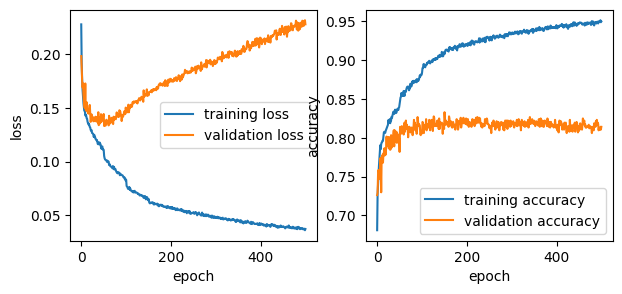

In [24]:
from matplotlib import pyplot as plt

fix, ax = plt.subplots(1, 2, figsize=(7,3))
ax[0].plot(history.history["loss"], label="training loss")
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()


In [25]:
predict = model.predict(cnn_feat_test)
predict = predict.argmax(axis=1)

116/116 [==============================] - 0s 957us/step


In [26]:
predict = [labels[x] for x in predict]
predict[:10]

['FT',
 'VOIP',
 'CHAT',
 'STREAMING',
 'VOIP',
 'CHAT',
 'VOIP',
 'VOIP',
 'VOIP',
 'MAIL']

In [27]:
y_hat = cnn_y_test.argmax(axis=1)
y_hat = [labels[x] for x in y_hat]
y_hat[:10]

['FT',
 'VOIP',
 'BROWSING',
 'STREAMING',
 'VOIP',
 'FT',
 'VOIP',
 'VOIP',
 'VOIP',
 'CHAT']

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(pred, y):    
    print(classification_report(y, pred))
    print(confusion_matrix(y, pred), "\n")

In [29]:
evaluate_model(predict, y_hat)

              precision    recall  f1-score   support

    BROWSING       0.79      0.83      0.81      1083
        CHAT       0.57      0.57      0.57       416
          FT       0.70      0.65      0.67       438
        MAIL       0.72      0.78      0.75       107
         P2P       0.66      0.47      0.55       143
   STREAMING       0.80      0.79      0.79       211
        VOIP       0.98      0.98      0.98      1313

    accuracy                           0.81      3711
   macro avg       0.74      0.72      0.73      3711
weighted avg       0.81      0.81      0.81      3711

[[ 895  106   51   13    7   10    1]
 [ 118  239   33   10    9    4    3]
 [  76   50  285    7   13    6    1]
 [  11    5    7   83    1    0    0]
 [   9   13   18    0   67   16   20]
 [  25    4   11    1    3  166    1]
 [   4    6    5    1    2    6 1289]] 



In [30]:
model.save_weights("tensorflow_cnn")

# Models are trained, compared cpu/memory and ops per second

In [31]:
rf_feat_test.shape

(3711, 23)

In [32]:
cnn_feat_test.shape

(3711, 23)

In [51]:
for i in range (5):
    with timeit("Predict with Random forest"):
        for i in range(3000):
            pred = rf_20_model.predict(rf_feat_test)

Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.688s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.640s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.530s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.830s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.977s


In [52]:
for i in range(5):
    with timeit("Predict with Random forest"):
        for i in range(100):
            predict = model.predict(cnn_feat_test, verbose=0)
            predict = predict.argmax(axis=1)

Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.094s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 12.821s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.023s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.069s
Predict with Random forest started...
Predict with Random forest completed. Elapsed time: 13.443s


In [59]:
rf_times = np.array([13.688, 13.640, 13.530, 13.830, 13.977])
rf_avg = rf_times.mean()
cnn_times = np.array([13.094, 12.821, 13.023, 13.069, 13.443])
cnn_avg = rf_times.mean()


rf_ops = (3000.0*3711.0)/rf_avg
cnn_ops = (100.0*3711.0)/cnn_avg
print(f"Random Forest: {rf_ops:.2f}")
print(f"    CNN model: {cnn_ops:.2f}")
print(f" RF:CNN ratio: {rf_ops/cnn_ops} times as many ops per second")

Random Forest: 810675.02
    CNN model: 27022.50
 RF:CNN ratio: 30.0 times as many ops per second


In [62]:
import os
rf_size = os.path.getsize("sklearn_rfc_20.model")
cnn_size = os.path.getsize("tensorflow_cnn.data-00000-of-00001")

print(f"Random Forest: {rf_size/1024/1024:.2f} MB")
print(f"    CNN model: {cnn_size/1024/1024:.2f} MB")
print(f" RF:CNN ratio: {rf_size/cnn_size*100:.2f} % of the size")

Random Forest: 4.05 MB
    CNN model: 5.22 MB
 RF:CNN ratio: 77.50 % of the size
